# @andreanne 

ABIDE TEAM PROJECT ON MACHINE LEARNING

In [195]:
#Import librairies

import os
import pandas as pd
import numpy as np
import prepare_data

import nilearn as nl
from nilearn import plotting as nlp
from nilearn import datasets
from nilearn import image
from nilearn.image import load_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans

In [157]:
output_dir = "/home/anproulx/connectomes_fetched"

Prepare X_features 

In [4]:
# get dataset
abide = datasets.fetch_abide_pcp(pipeline = "cpac",
                                 quality_checked = True)

/home/anproulx/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [62]:
#X, y = prepare_data.prepare_data(data_dir, output_dir) 

In [20]:
def prepare_data(output_dir):
  
    # make list of filenames
    fmri_filenames = abide.func_preproc

    # load atlas
    multiscale = datasets.fetch_atlas_basc_multiscale_2015()
    atlas_filename = multiscale.scale064

    # initialize masker object
    masker = NiftiLabelsMasker(labels_img=atlas_filename,
                               standardize=True,
                               memory='nilearn_cache',
                               verbose=0)

    # initialize correlation measure
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                             discard_diagonal=True)

    try: # check if feature file already exists
        # load features
        feat_file = os.path.join(output_dir, 'ABIDE_BASC064_features.npz')
        X_features = np.load(feat_file)['a']
        print("Feature file found.")

    except: # if not, extract features
        X_features = [] # To contain upper half of matrix as 1d array
        print("No feature file found. Extracting features...")

        for i,sub in enumerate(fmri_filenames):
            # extract the timeseries from the ROIs in the atlas
            time_series = masker.fit_transform(sub)
            # create a region x region correlation matrix
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # add to our container
            X_features.append(correlation_matrix)
            # keep track of status
            print('finished extracting %s of %s'%(i+1,len(fmri_filenames)))
        # Save features
        np.savez_compressed(os.path.join(output_dir, 'ABIDE_BASC064_features'),
                                         a = X_features)

    # Dimensionality reduction of features with PCA
    print("Running PCA...")
    pca = PCA(0.99).fit(X_features) # keeping 99% of variance
    X_features_pca = pca.transform(X_features)

    # Transform phenotypic data into dataframe
    abide_pheno = pd.DataFrame(abide.phenotypic)

    # Get the target vector
    y_target = abide_pheno['DX_GROUP']

    return X_features_pca, y_target

In [6]:
prepare_data(output_dir)

No feature file found. Extracting features...
finished extracting 1 of 871
finished extracting 2 of 871
finished extracting 3 of 871
finished extracting 4 of 871
finished extracting 5 of 871
finished extracting 6 of 871
finished extracting 7 of 871
finished extracting 8 of 871
finished extracting 9 of 871
finished extracting 10 of 871
finished extracting 11 of 871
finished extracting 12 of 871
finished extracting 13 of 871
finished extracting 14 of 871
finished extracting 15 of 871
finished extracting 16 of 871
finished extracting 17 of 871
finished extracting 18 of 871
finished extracting 19 of 871
finished extracting 20 of 871
finished extracting 21 of 871
finished extracting 22 of 871
finished extracting 23 of 871
finished extracting 24 of 871
finished extracting 25 of 871
finished extracting 26 of 871
finished extracting 27 of 871
finished extracting 28 of 871
finished extracting 29 of 871
finished extracting 30 of 871
finished extracting 31 of 871
finished extracting 32 of 871
fin

(array([[ 5.08201869e+00,  2.54871751e+00,  2.83103836e+00, ...,
          6.32870071e-02,  1.74101107e-02,  1.62016414e-01],
        [ 6.47459751e-01,  1.38423680e+00, -7.93556459e-01, ...,
          1.08540292e-01,  1.07175932e-02, -3.29055886e-02],
        [ 4.71250228e+00, -1.93336238e+00,  5.46511190e-01, ...,
         -6.85600670e-02, -1.26331469e-02, -2.56215257e-02],
        ...,
        [-3.18352284e+00,  2.71231822e+00,  3.44123152e-01, ...,
          5.70292731e-02,  1.29969602e-02,  8.70286300e-02],
        [-7.27850481e+00, -5.88361790e-01, -5.62045946e-01, ...,
          1.14576044e-01, -7.12354516e-02, -3.04468511e-03],
        [ 2.83170858e+00, -2.16417785e+00, -2.35660724e-01, ...,
          2.55865064e-02,  2.80488791e-03,  9.49094507e-02]]),
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 866    1
 867    1
 868    1
 869    1
 870    1
 Name: DX_GROUP, Length: 871, dtype: int64)

In [158]:
feat_file = os.path.join(output_dir, 'ABIDE_BASC064_features.npz')
X_features = np.load(feat_file)['a']

#X_features.shape

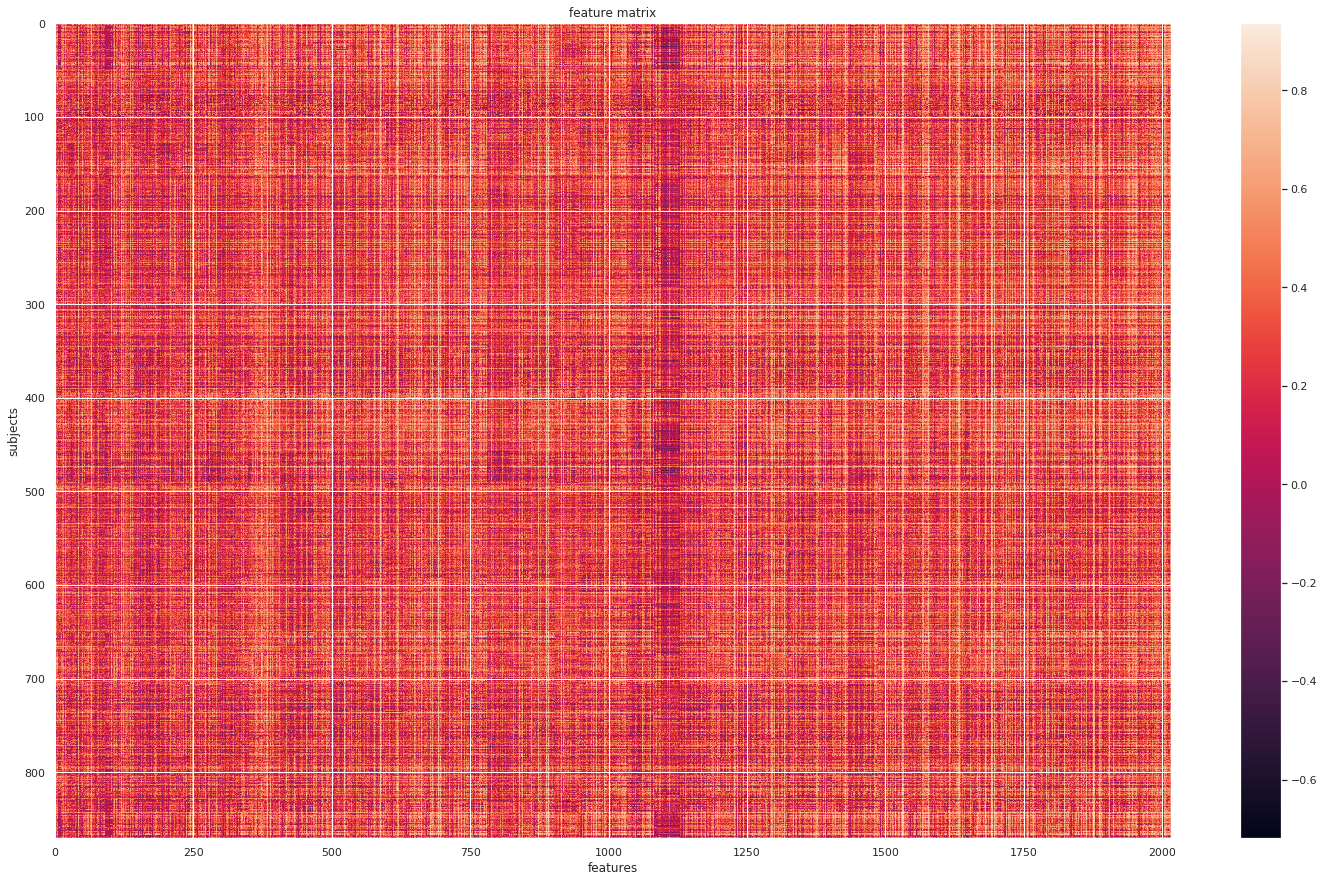

In [159]:
#Plot feature matrix

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

plt.gcf().set_size_inches(25, 15)

# Machine learning : classification algorithms

For each estimator:

1. Explore the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values

2. Define a grid range and use SearchGrid to choose the value of multiple hyperparameters simultanously

Using k-fold and leave-one out cross validation: 

3. Fit the model to the training data
4. Predict labels of test data 
5. Compare to real labels
6. Average the performance across all folds

In [160]:
#Define functions to compute accuracy mean and std 

def compute_acc_std_mean (train_scores, test_scores):
    #train scores
    train_scores_mean= np.mean(train_scores, axis=1)
    train_scores_std= np.std(train_scores, axis=1)
    
    #test scores
    test_scores_mean= np.mean(test_scores, axis=1)
    test_scores_std= np.std(test_scores, axis=1)
    
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

In [161]:
#Define function to plot validation curve

def plot_validationcurve (param, param_range, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std):
    plt.title("Validation Curve")
    plt.xlabel("Hyperparameter : {}".format(param))
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw=2
    #plot train scores
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    #plot test scores
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    
    plt.legend(loc="best")
    plt.gcf().set_size_inches(25, 15)
    
    return plt.show()

In [162]:
# Function returning the best estimator

def best_estimator(model, param_grid, X, y, cv):
    grid = GridSearchCV (model, param_grid, cv=cv)
    grid.fit(X, y)
    model_best= grid.best_estimator_
    param_best= grid.best_params_
    
    return model_best , param_best

In [163]:
#Get target vector
y_target=abide.phenotypic["DX_GROUP"]

# Support Vector Machines (SVM)

Finds a line or curve (in two dimensions) or manifold (in multiple dimensions)
that divides the classes from each other. In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.  Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is
a challenging regime for other algorithms.

C parameter: The hardness of the margin is controlled by a tuning parameter, most
often known as C. For very large C, the margin is hard, and points cannot lie in it. For
smaller C, the margin is softer, and can grow to encompass some points.

*Source Python Data Science Handbook

In [29]:
model_SVC = SVC()

In [75]:
#plot validation curve for gamma parameter
param_range_SVM= np.logspace (-6, 2 , 20)

train_scores_SVM, test_scores_SVM= validation_curve(
    SVC(), X_features, y_target, param_name="gamma", param_range=param_range_SVM,
    scoring="accuracy", n_jobs=1)

In [77]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_SVM, test_scores_SVM)

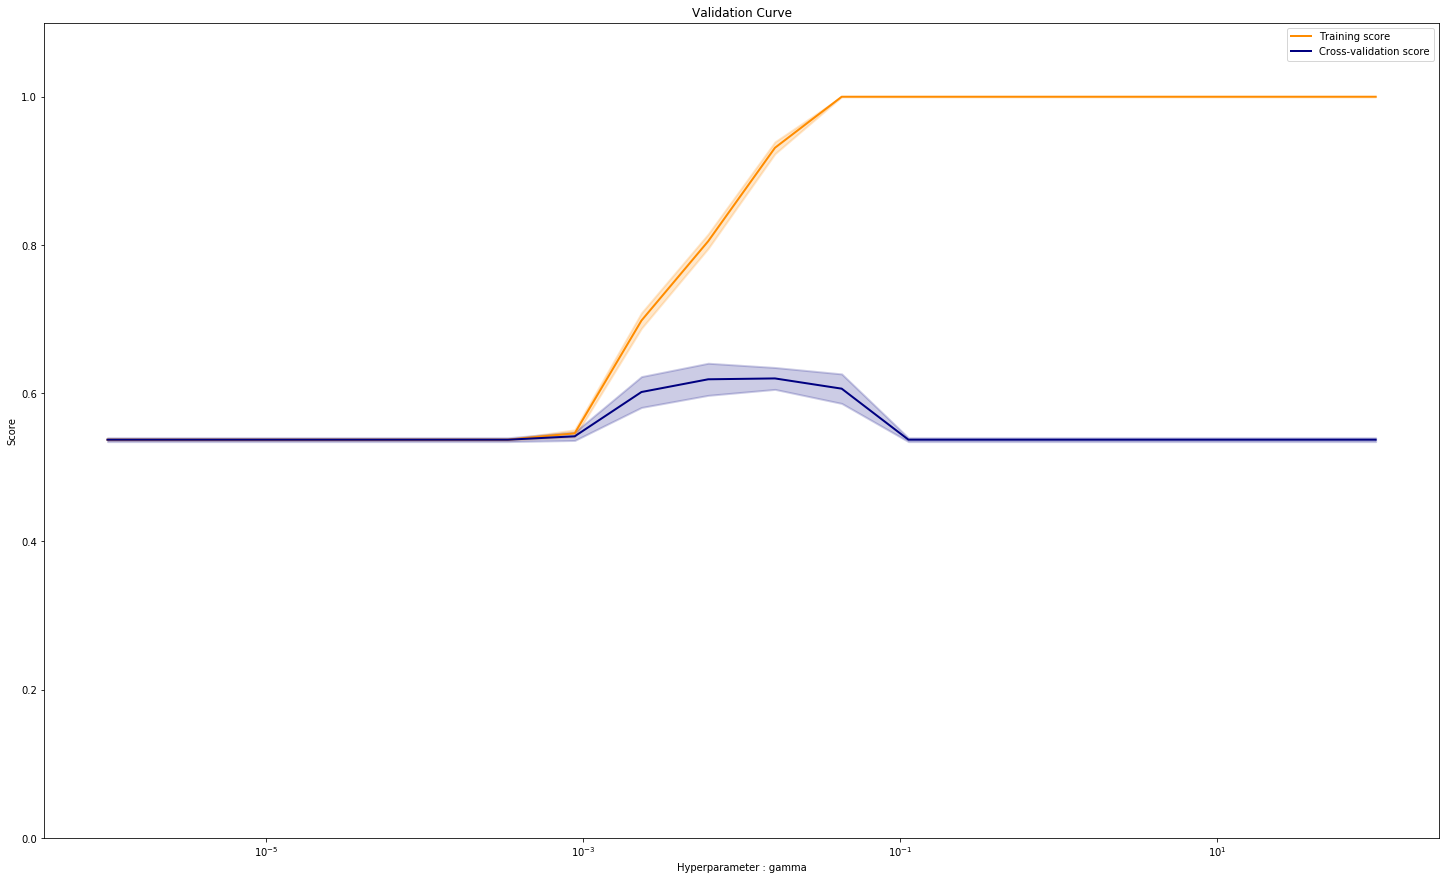

In [78]:
plot_validationcurve("gamma", param_range_SVM, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [79]:
train_scores_C, test_scores_C= validation_curve(
    SVC(), X_features, y_target, param_name="C", param_range=param_range_SVM,
    scoring="accuracy", n_jobs=1)

In [82]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_C, test_scores_C)

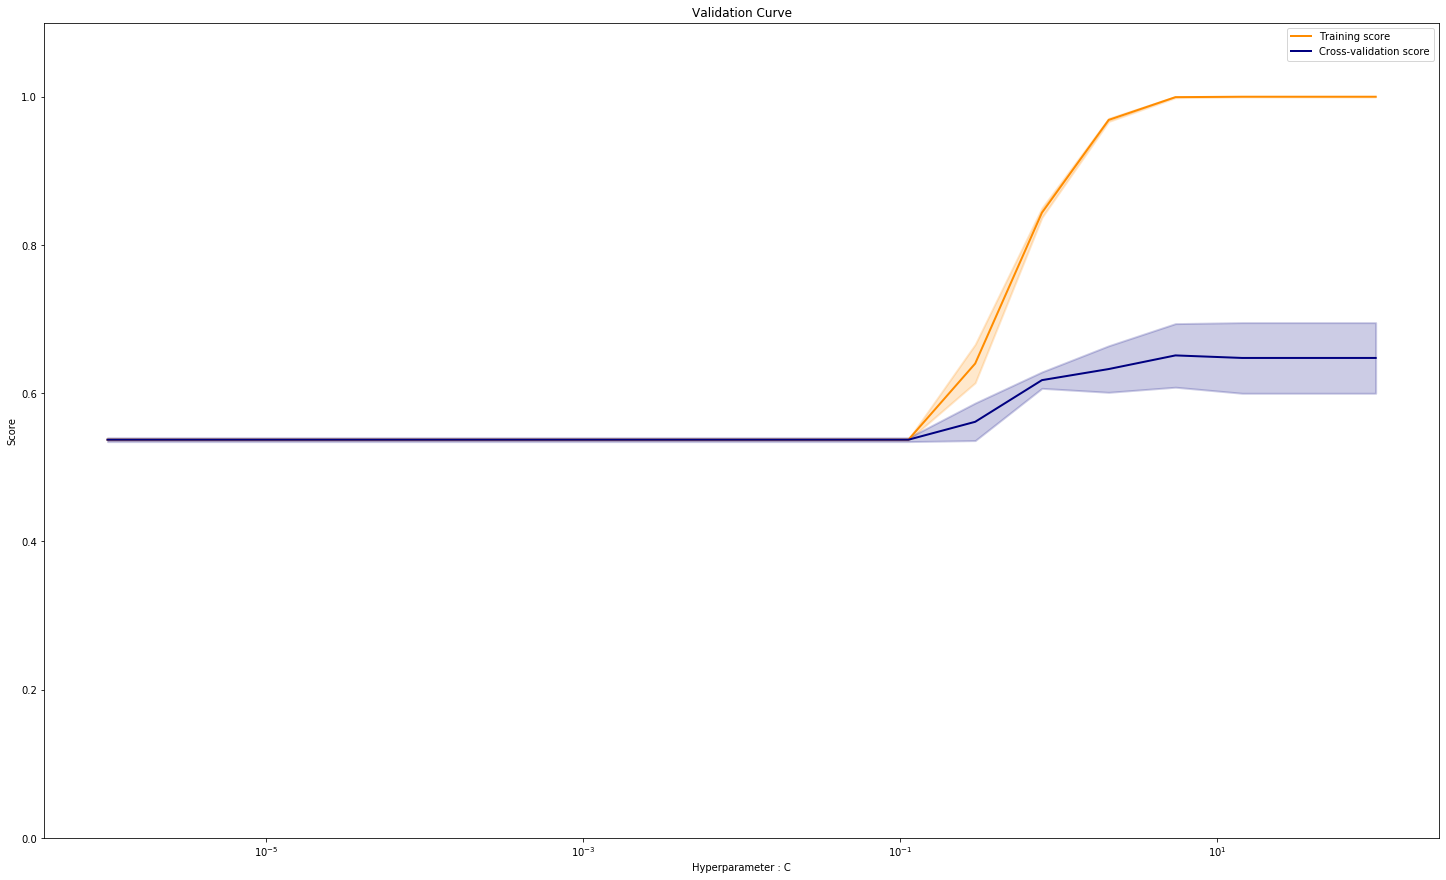

In [86]:
#plot validation curve for c hyperparameter
plot_validationcurve("C", param_range_SVM, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [88]:
#Find best estimator 

param_grid_SVC = {'C': [0.01, 0.1, 1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4,  5, 10],
              'gamma': [0.00001, 0.00005,  0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 3.5, 5, 10]}

best_estimator(model_SVC, param_grid_SVC, X_features, y_target, 10)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [92]:
#Define the result the best model

model_best = SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

k-fold cross validation

In [96]:
score_kfold=cross_val_score(model_best, X_features, y_target, cv=10).mean() #cv is the number of folds
print(score_kfold)

0.6762016718913271


Leave-one out cross validation

In [98]:
score_leave_one_out= cross_val_score(model_best, X_features, y_target, cv=LeaveOneOut()).mean()
print(score_leave_one_out)

0.6923076923076923


In [102]:
svm_scores= [score_kfold, score_leave_one_out]

In [103]:
#create dataframe to store accuracy scores

classification_accuracy=pd.DataFrame()
classification_accuracy["SVM"]= svm_scores
classification_accuracy.set_axis(['KFold', 'LeaveOneOut'], axis='index')

SVM
KFold        0.676202
LeaveOneOut  0.692308

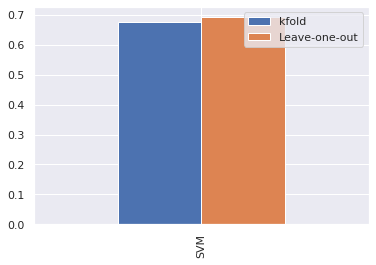

In [126]:
sns.set()
classification_accuracy.T.plot(kind='bar').legend(['kfold', 'Leave-one-out'])


# K Neirest Neighbor (KNN)

The KNN algorithm is a robust and versatile classifier that is often used as a reference for more complex classifiers such as Artificial Neural Networks (ANNs) and Support Vector Machines (SVMs).

KNN is supervised learning and works with labeled data sets including learning observations (x, y) and is used to capture the relationship between x and y (x = entity, predictor, attribute; y = target, label, class).

The KNN algorithm forms a majority vote between the K instances most similar to a given "invisible" observation.The similarity is defined according to a distance metric between two data points (common choices: Euclidean distance, Manhattan, Chebyshev, Hamming).

*Source: Python Data Science Handbook

In [202]:
#plot validation curve for n-neighbors hyperparameter
param_range_neig = np.arange (1, 50, 1)

In [203]:
train_scores_neig, test_scores_neig = validation_curve(
    KNN(), X_features, y_target, param_name="n_neighbors", param_range=param_range_neig,
    scoring="accuracy", n_jobs=1)

In [204]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_neig, test_scores_neig)

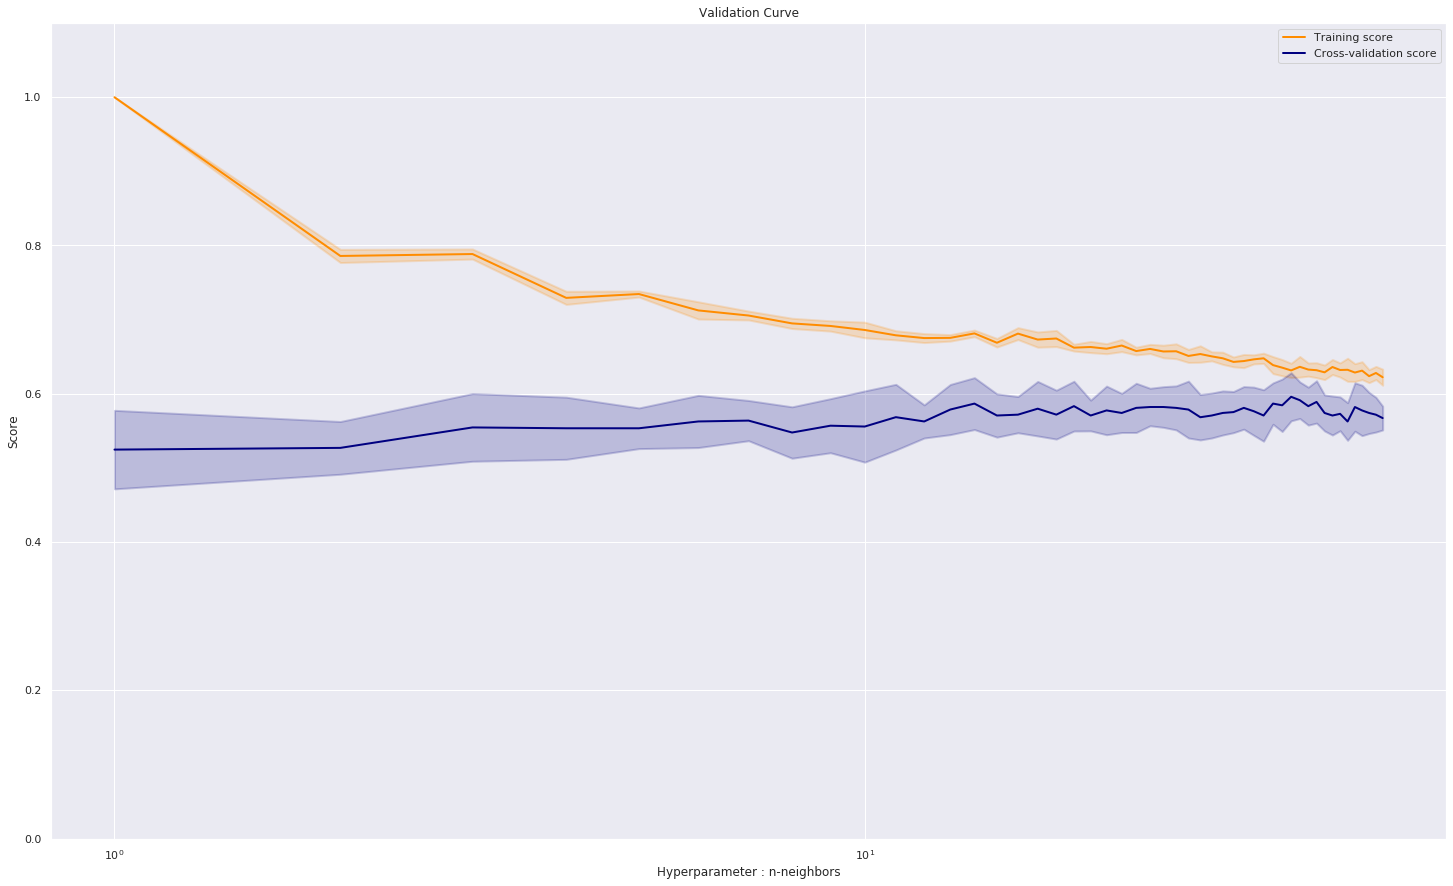

In [205]:
plot_validationcurve("n-neighbors", param_range_neig, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [139]:
#Find the best estimator

model_KNN = KNN()

param_grid = {'n_neighbors': [1, 2 , 3, 4, 6, 10, 15, 20, 25, 30, 50, 100],
              'algorithm':['auto', 'kd_tree']}

best_estimator(model_KNN, param_grid, X_features, y_target, 10)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [147]:
#Select the best estimator

model_best_KNN=KNN(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

K fold cross validation

In [150]:
score_kfold_knn =cross_val_score(model_best_KNN, X_features, y_target, cv=10).mean() #cv is the number of folds
print("The accuracy score for 10-folds is : " , score_kfold_knn)

The accuracy score for 10-folds is :  0.5774164054336468


Leave one out cross validation

In [152]:
score_leave_one_out_knn = cross_val_score(model_best_KNN, X_features, y_target, cv=LeaveOneOut()).mean()
print("The accuracy score for leave-one out is: ", score_leave_one_out_knn)

The accuracy score for leave-one out is:  0.5843857634902411


In [154]:
#add to the dataframe 
KNN_scores= [score_kfold_knn, score_leave_one_out_knn]
classification_accuracy["KNN"]= KNN_scores

In [155]:
classification_accuracy

SVM       KNN
0  0.676202  0.577416
1  0.692308  0.584386

# Decision Tree

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. 
Deepness of the tree: Going to deep in the levels of the tree can lead to overfitting the data. 

*Source: Python Data Science Handbook

In [171]:
#plot validation curve for deepness level hyperparameter
param_range_tree = np.arange (1, 11 , 1)

#model_tree = DecisionTreeClassifier()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [175]:
train_scores_tree, test_scores_tree = validation_curve(
    DecisionTreeClassifier(), X_features, y_target, param_name="max_depth", param_range=param_range_tree,
    scoring="accuracy", n_jobs=1)

In [176]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_tree, test_scores_tree)

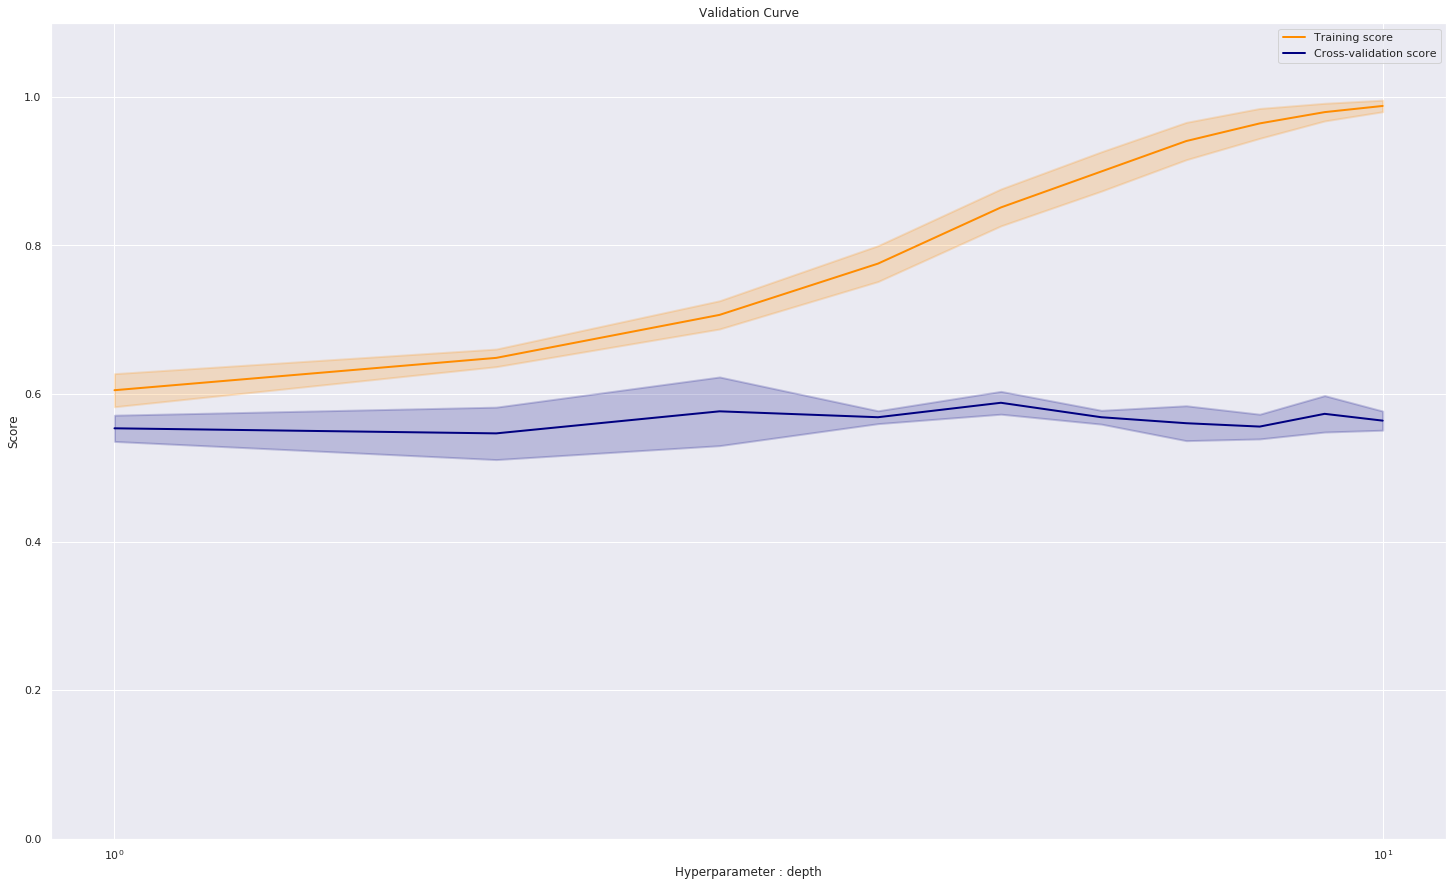

In [177]:
plot_validationcurve("depth", param_range_tree, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

Get the best estimator in regard to depth parameter

In [178]:
#Find the best model 

#model.get_params().keys()
model_tree = DecisionTreeClassifier()
param_grid = {'max_depth': [1, 2 , 3, 4, 5, 6, 10]}

best_estimator(model_tree, param_grid, X_features, y_target, 10)

(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 {'max_depth': 3})

In [184]:
#Slect the best model
model_best_tree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best')
                                        
score_kfold =cross_val_score (model_best_tree, X_features, y_target, cv=10).mean() #cv is the number of folds
print("The accuracy score for 10-folds is : " , score_kfold)

The accuracy score for 10-folds is :  0.5589994775339602


In [188]:
score_leave_one_out = cross_val_score (model_best_tree, X_features, y_target, cv=LeaveOneOut()).mean()
print("The accuracy score for leave-one out is: ", score_leave_one_out)

The accuracy score for leave-one out is:  0.669345579793341


# Random forests

Ensemble of decision tree classifiers (bagging). Random forests are an example of an ensemble learner built on decision trees. The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using
information from both of multiple trees, we might come up with a better result. That's where bagging methods, in this case Random Forests, comes into place. 

*Source: Python Data Science Handbook

In [190]:
bag_tree = BaggingClassifier(model_best_tree, n_estimators=100, max_samples=0.8,
random_state=1)

score =cross_val_score (bag_tree, X_features, y_target, cv=10).mean() #cv is the number of folds
print("The accuracy score for 10-folds is : " , score)

The accuracy score for 10-folds is :  0.6246081504702194


In [194]:
score = cross_val_score (bag_tree, X_features, y_target, cv=LeaveOneOut()).mean()
print("The accuracy score for leave-one out is: ", score)

The accuracy score for leave-one out is:  0.6383467278989667


# KMEAN

Clustering within the autism group. Do we find distinctive subclasses for 1) asperger, 2) PPD-NOS (persuasive developmental disorder) and 3) autism. Do these subclasses get connectomes that are different enough, such that they are conceptually validated by unsupervised clustering? Defining subclasses within the autism group: unsupervised estimators can highlight interesting aspects of the data
without reference to any known labels. 

In [ ]:
subclasses_autism=abide.phenotypic["DSM_IV_TR"]

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_features_pca)
kmeans.labels_

In [ ]:
#Compare the amount of overlap between the defined subgroups

How to increases the accuracy of estimators

Of core importance is the following question: if our estimator is underperforming, how
should we move forward? There are several possible answers:

• Use a more complicated/more flexible model
• Use a less complicated/less flexible model
• Gather more training samples
• Gather more data to add features to each sample

*Source Python Data Science Handbook